# Интерпретация графовых нейронных сетей

In [3]:
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric~=2.0.4 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q captum==0.6.0

import torch
import numpy as np

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def set_seed():
    """
    Задает стартовое значение генератора псевдослучайных
    чисел для воспроизводимости.
    """
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    np.random.seed(0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 60.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## GNNExplainer

In [4]:
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool, GNNExplainer

set_seed()

dataset = TUDataset(root='data/TUDataset', name='MUTAG').shuffle()

# создаем обучающий, проверочный и тестовый наборы
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

# создаем мини-батчи
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        h = torch.cat((h1, h2, h3), dim=1)

        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return F.log_softmax(h, dim=1)

model = GIN(dim_h=32)

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 200

model.train()
for epoch in range(epochs+1):
    total_loss = 0
    acc = 0
    val_loss = 0
    val_acc = 0

    # Обучаем на батчах
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss / len(train_loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(train_loader)
        loss.backward()
        optimizer.step()

        # Проверка
        val_loss, val_acc = test(model, val_loader)

    # Печатаем метрики через каждые 20 эпох
    if epoch % 20 == 0:
        print(f'Эпоха {epoch:>3}:\n| Функция потерь на обуч. наборе: '
              f'{total_loss:.2f} | Правильность на обуч. наборе: '
              f'{acc*100:>5.2f}% \n| Функция потерь на провер. наборе: '
              f'{val_loss:.2f} | Правильность на провер. наборе: '
              f'{val_acc*100:.2f}%')

test_loss, test_acc = test(model, test_loader)
print(f'\nФункция потерь на тестовом наборе: {test_loss:.2f} | '
      f'Правильность на тестовом наборе: {test_acc*100:.2f}%')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


Эпоха   0:
| Функция потерь на обуч. наборе: 1.93 | Правильность на обуч. наборе: 65.39% 
| Функция потерь на провер. наборе: 0.61 | Правильность на провер. наборе: 68.42%
Эпоха  20:
| Функция потерь на обуч. наборе: 0.46 | Правильность на обуч. наборе: 79.88% 
| Функция потерь на провер. наборе: 0.35 | Правильность на провер. наборе: 89.47%
Эпоха  40:
| Функция потерь на обуч. наборе: 0.39 | Правильность на обуч. наборе: 82.48% 
| Функция потерь на провер. наборе: 0.33 | Правильность на провер. наборе: 94.74%
Эпоха  60:
| Функция потерь на обуч. наборе: 0.33 | Правильность на обуч. наборе: 81.44% 
| Функция потерь на провер. наборе: 0.35 | Правильность на провер. наборе: 89.47%
Эпоха  80:
| Функция потерь на обуч. наборе: 0.39 | Правильность на обуч. наборе: 77.89% 
| Функция потерь на провер. наборе: 0.54 | Правильность на провер. наборе: 68.42%
Эпоха 100:
| Функция потерь на обуч. наборе: 0.37 | Правильность на обуч. наборе: 81.53% 
| Функция потерь на провер. наборе: 0.21 | Правиль

In [5]:
explainer = GNNExplainer(model, epochs=100, num_hops=1)
data = dataset[-1]
feature_mask, edge_mask = explainer.explain_graph(data.x, data.edge_index)
feature_mask

Explain graph: 100%|██████████| 100/100 [00:00<00:00, 136.89it/s]


tensor([0.6788, 0.6915, 0.6694, 0.2613, 0.2655, 0.2748, 0.2574])

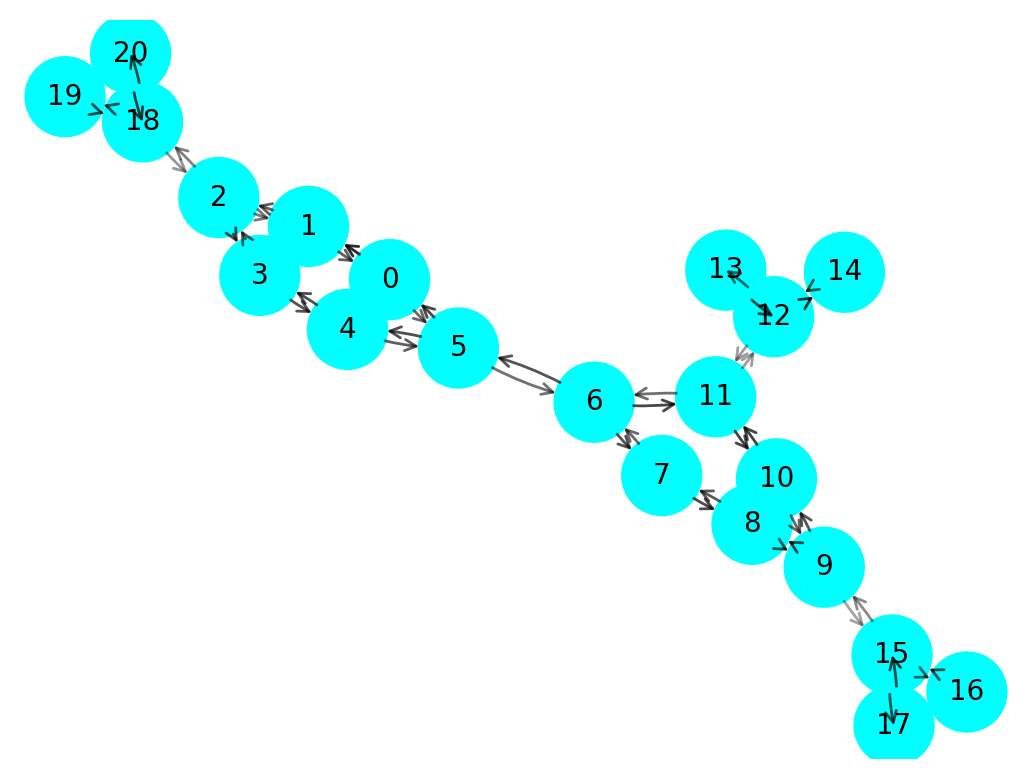

In [6]:
fig = plt.figure(dpi=200)
ax, G = explainer.visualize_subgraph(
    -1, data.edge_index, edge_mask, y=data.y
)
ax.axis('off')
plt.show()

## Интерпретация результатов GNN с помощью библиотеки Captum

In [7]:

from captum.attr import IntegratedGradients

import torch_geometric.transforms as T
from torch_geometric.datasets import Twitch
from torch_geometric.nn import Explainer, GCNConv, to_captum

set_seed()

dataset = Twitch('.', name="EN")
data = dataset[0]

class GCN(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv2(h, edge_index)
        return F.log_softmax(h, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index)
    loss = F.nll_loss(log_logits, data.y)
    loss.backward()
    optimizer.step()

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1), data.y)
    return acc

acc = test(model, data)
print(f'Правильность: {acc*100:.2f}%')

Processing...
Done!


Правильность: 68.80%


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


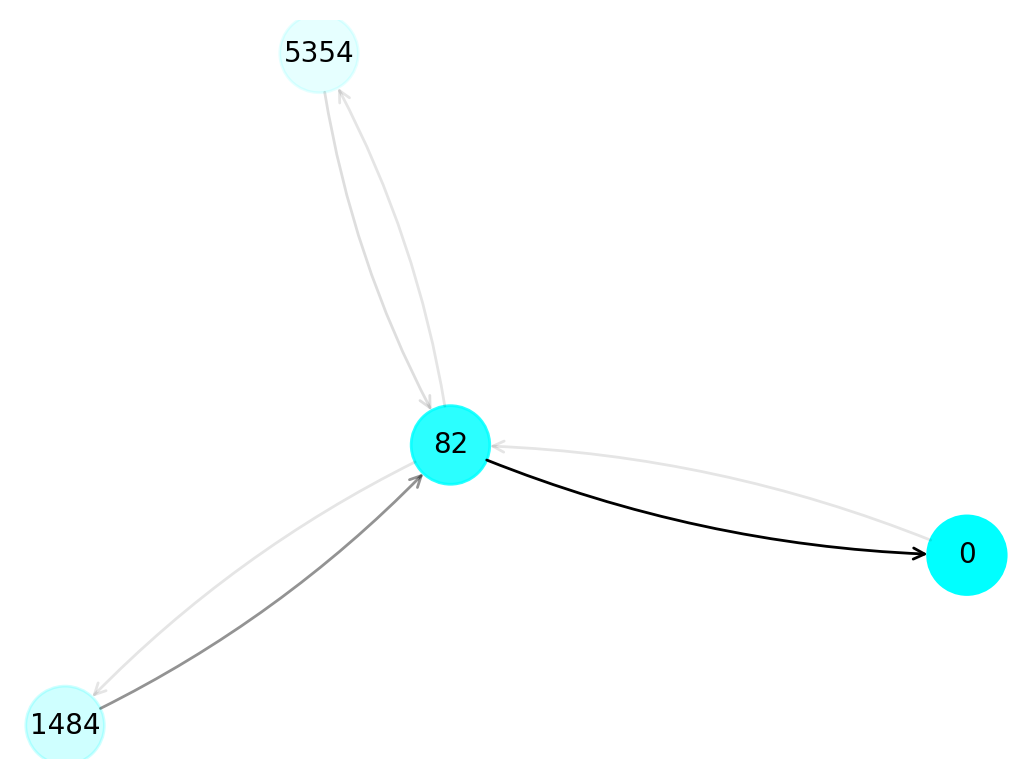

In [8]:
node_idx = 0
captum_model = to_captum(model,
                         mask_type='node_and_edge',
                         output_idx=node_idx)
ig = IntegratedGradients(captum_model)
edge_mask = torch.ones(data.num_edges,
                       requires_grad=True,
                       device=device)

attr_node, attr_edge = ig.attribute(
    (data.x.unsqueeze(0), edge_mask.unsqueeze(0)),
    target=int(data.y[node_idx]),
    additional_forward_args=(data.edge_index),
    internal_batch_size=1)

attr_node = attr_node.squeeze(0).abs().sum(dim=1)
attr_node /= attr_node.max()
attr_edge = attr_edge.squeeze(0).abs()
attr_edge /= attr_edge.max()

fig = plt.figure(dpi=200)
explainer = Explainer(model)
ax, G = explainer.visualize_subgraph(
    node_idx, data.edge_index, attr_edge,
    node_alpha=attr_node, y=data.y
)
ax.axis('off')
plt.show()

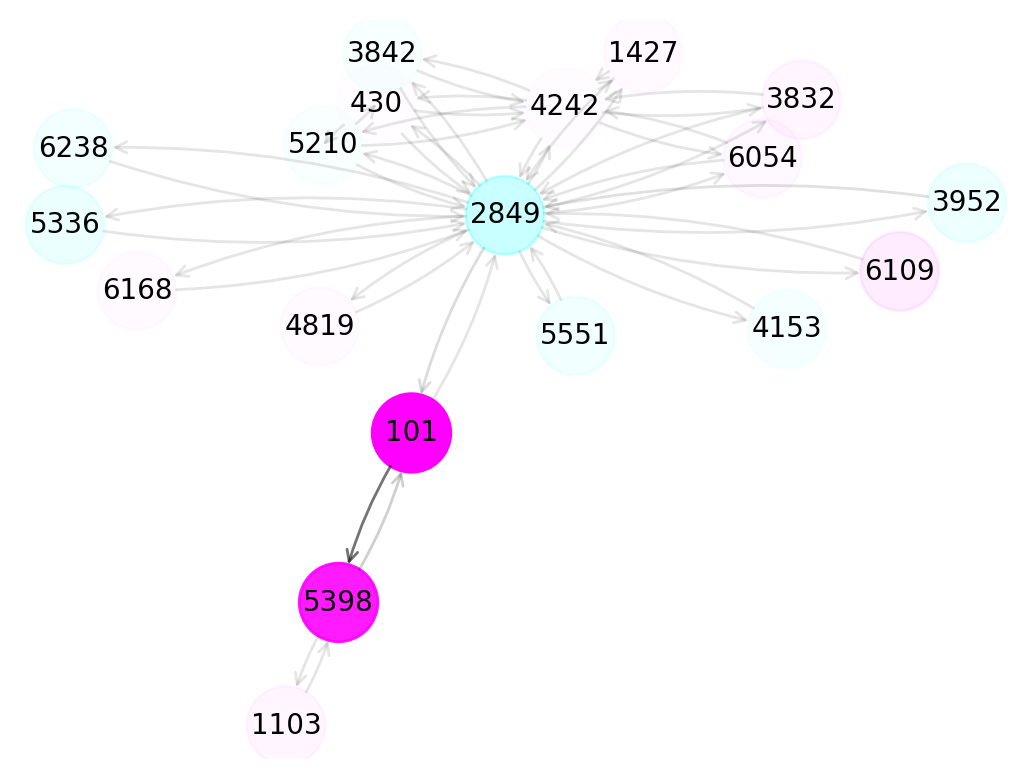

In [9]:
node_idx = 101
captum_model = to_captum(model,
                         mask_type='node_and_edge',
                         output_idx=node_idx)
ig = IntegratedGradients(captum_model)
edge_mask = torch.ones(data.num_edges,
                       requires_grad=True,
                       device=device)

attr_node, attr_edge = ig.attribute(
    (data.x.unsqueeze(0), edge_mask.unsqueeze(0)),
    target=int(data.y[node_idx]),
    additional_forward_args=(data.edge_index),
    internal_batch_size=1)

attr_node = attr_node.squeeze(0).abs().sum(dim=1)
attr_node /= attr_node.max()
attr_edge = attr_edge.squeeze(0).abs()
attr_edge /= attr_edge.max()

fig = plt.figure(dpi=200)
explainer = Explainer(model)
ax, G = explainer.visualize_subgraph(
    node_idx, data.edge_index,
    attr_edge, node_alpha=attr_node, y=data.y
)
ax.axis('off')
plt.show()